### script to apply SSK BO over a set of candidate strings
### we demonstrate on the task of finding moelcules  with high scores

In [1]:
import numpy as np
import pickle
import gzip
import emukit
import re
import matplotlib.pyplot as plt
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace
from emukit.core.optimization import RandomSearchAcquisitionOptimizer
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.core.loop import FixedIterationsStoppingCondition
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import our code
from boss.code.parameters.candidate_parameter import CandidateStringParameter
from boss.code.optimizers.StringGeneticAlgorithmAcquisitionOptimizer import StringGeneticProgrammingOptimizer
from boss.code.emukit_models.emukit_bow_model import BOW_model
from boss.code.emukit_models.emukit_linear_model import linear_model
from boss.code.emukit_models.emukit_ssk_model import SSK_model

# Explain Methods

In [3]:
# we perform optimziation using our SSK-approach and random search
# VAE baselines are availible for Grammar VAEs and Character VAES at https://github.com/mkusner/grammarVAE

# Collect candidate strings 

In [4]:
# get 250,000 candidate molecules
file = gzip.GzipFile("../example_data/SMILES/SMILES.gzip", 'rb')
data = file.read()
smiles_full = pickle.loads(data)
file.close()
# get their scores
file = gzip.GzipFile("../example_data/SMILES/TARGETS.gzip", 'rb')
data = file.read()
targets_full = pickle.loads(data)
file.close()
# for tutorial only keep strings <40 length (for quick SSK)
smiles=[]
targets=[]
for i in range(0,len(smiles_full)):
    if len(smiles_full[i])<40:
        smiles.append(smiles_full[i])
        targets.append(targets_full[i])
smiles=np.array(smiles)
targets=np.array(targets)

#seperate all character with blank space
smiles = np.array([" ".join(list(smile)) for smile in smiles]).reshape(-1,1)



# Define problem (objective and space)

In [5]:
# define an objective function (to be minimized) and space 
def objective(x):
    # return score of the molecules
    # *-1 so we can minimize
    return -targets[np.where(smiles==x)[0][0]]
objective=np.vectorize(objective)
# define search space
space = ParameterSpace([CandidateStringParameter("string",smiles)])

# Collect initial points

In [6]:
# collect initial design (uniform sample)
np.random.seed(1234)
random_design = RandomDesign(space)
initial_points_count = 15
X_init = random_design.get_samples(initial_points_count)
Y_init = objective(X_init)

# Perform BO with SSK

In [7]:
# build BO loop
# fit SSK model
# just a single restart when fitting kernel params for demo 
# (we recommend at least 3 for high performance)
model =SSK_model(space,X_init,Y_init,max_subsequence_length=5,n_restarts=1)
# Load core elements for Bayesian optimization
expected_improvement = ExpectedImprovement(model)
# use random search to optimize acqusition function
optimizer = RandomSearchAcquisitionOptimizer(space,100)
bayesopt_loop_ssk = BayesianOptimizationLoop(model = model, 
                                         space = space,
                                         acquisition = expected_improvement,
                                         acquisition_optimizer = optimizer)
# add loop summary
def summary(loop, loop_state):
    print("Performing BO step {}".format(loop.loop_state.iteration))
bayesopt_loop_ssk.iteration_end_event.append(summary)

reconstraining parameters GP_regression.sk.Gap_decay
reconstraining parameters GP_regression.sk.Match_decay


In [8]:
# run BO loop for 10 steps 
stopping_condition = FixedIterationsStoppingCondition(i_max = 35) 
bayesopt_loop_ssk.run_loop(objective, stopping_condition)

Optimization restart 1/1, f = 19.187225084021048
Performing BO step 1
Optimization restart 1/1, f = 19.467343308047404
Performing BO step 2
Optimization restart 1/1, f = 22.16853567860297
Performing BO step 3
Optimization restart 1/1, f = 22.957946170821735
Performing BO step 4
Optimization restart 1/1, f = 23.740146166171453
Performing BO step 5
Optimization restart 1/1, f = 24.650012279227404
Performing BO step 6
Optimization restart 1/1, f = 25.825125558890218
Performing BO step 7
Optimization restart 1/1, f = 26.600635185814888
Performing BO step 8
Optimization restart 1/1, f = 27.367796030291274
Performing BO step 9
Optimization restart 1/1, f = 27.823581210645568
Performing BO step 10
Optimization restart 1/1, f = 28.452241448965133
Performing BO step 11
Optimization restart 1/1, f = 29.63851308700287
Performing BO step 12
Optimization restart 1/1, f = 30.12760086542307
Performing BO step 13
Optimization restart 1/1, f = 30.387036896158225
Performing BO step 14
Optimization resta

# Perform random search

In [9]:
# also see performance of random search 
#(starting from the initialization used by the other approaches)
np.random.seed(1234)
Y_random=np.vstack([Y_init,objective(random_design.get_samples(35))])

# plot results

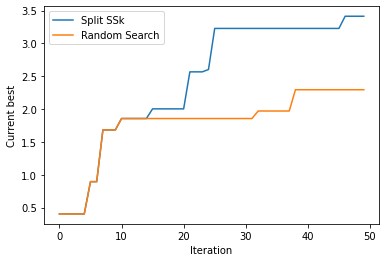

In [10]:
# plot results from the two methods
# recall that first 15 points are a random sample shared by all the methods
plt.plot(-np.minimum.accumulate(bayesopt_loop_ssk.loop_state.Y),label="Split SSk")
plt.plot(-np.minimum.accumulate(Y_random),label="Random Search")

plt.ylabel('Current best')
plt.xlabel('Iteration')
plt.legend()